## Problem Set 8: Simulating the Spread of Disease and Virus Population (continued from Problem Set 7) 

In [27]:
from random import random
import matplotlib
%matplotlib inline

In [29]:
class NoChildException(Exception):
    pass

class SimpleVirus(object):
    """
    Representation of a simple virus (does not model drug
    effects/resistance).
    """
    def __init__(self, maxBirthProb, clearProb):
        """
        Initialize a SimpleVirus instance, saves all parameters as attributes
        of the instance.
        maxBirthProb: Maximum reproduction probability (a float between 0-1)
        clearProb: Maximum clearance probability (a float between 0-1).
        """
        self.maxBirthProb = maxBirthProb
        self.clearProb = clearProb

    def doesClear(self):
        """
        Stochastically determines whether this virus particle is cleared from
        the patient's body at a time step.
        returns: True with probability self.clearProb and otherwise returns False.
        """
        return True if self.clearProb > random() else False

    def reproduce(self, popDensity):
        """
        Stochastically determines whether this virus particle reproduces at a
        time step. Called by the update() method in the SimplePatient and
        Patient classes. The virus particle reproduces with probability
        self.maxBirthProb * (1 - popDensity).
        If this virus particle reproduces, then reproduce() creates and
        returns
        the instance of the offspring SimpleVirus (which has the same
        maxBirthProb and clearProb values as its parent).
        popDensity: the population density (a float), defined as the current
        virus population divided by the maximum population.
        returns: a new instance of the SimpleVirus class representing the
        offspring of this virus particle. The child should have the same
        maxBirthProb and clearProb values as this virus. Raises a
        NoChildException if this virus particle does not reproduce.
        """
        if (self.maxBirthProb * (1 - popDensity)) > random():
            return SimpleVirus(self.maxBirthProb, self.clearProb)
        else:
            raise NoChildException('No child is being created')

In [31]:
class SimplePatient(object):
    """
    Representation of a simplified patient. The patient does not take any drugs
    and his/her virus populations have no drug resistance.
    """
    def __init__(self, viruses, maxPop):
        """
        Initialization function, saves the viruses and maxPop parameters as
        attributes.
        viruses: The list representing the virus population (a list of
        SimpleVirus instances)
        maxPop: The maximum virus population for this patient (an integer)
        """ 
        self.viruses = viruses
        self.maxPop = maxPop

    def getTotalPop(self):
        """
        Gets the current total virus population.
        returns: The total virus population (an integer)
        """
        return len(self.viruses)

    def update(self):
        """
        Update the state of the virus population in this patient for a single
        time step. update() should execute the following steps in this order:
        - Determine whether each virus particle survives and updates the list
        of virus particles accordingly.
        - The current population density is calculated. This population
        density value is used until the next call to update()
        - Determine whether each virus particle should reproduce and add
        offspring virus particles to the list of viruses in this patient.
        returns: the total virus population at the end of the update (an
        integer)
        """
        remaining_virus_population = []
        children = []
        for virus in self.viruses:
            if not virus.doesClear():
                remaining_virus_population.append(virus)
        self.viruses = remaining_virus_population
        current_population_density = self.getTotalPop() / self.maxPop
        for current_virus in self.viruses:
            try:
                children.append(current_virus.reproduce(current_population_density))
            except NoChildException:
                continue
        self.viruses = self.viruses + children
        return self.getTotalPop()

## Problem 1: Implementing a Simulation With Drugs

In [61]:
import numpy

class ResistantVirus(SimpleVirus):

    """
    Representation of a virus which can have drug resistance.
    """      

    def __init__(self, maxBirthProb, clearProb, resistances, mutProb):
        """

        Initialize a ResistantVirus instance, saves all parameters as attributes
        of the instance.

        maxBirthProb: Maximum reproduction probability (a float between 0-1)        
        clearProb: Maximum clearance probability (a float between 0-1).

        resistances: A dictionary of drug names (strings) mapping to the state
        of this virus particle's resistance (either True or False) to each drug.
        e.g. {'guttagonol':False, 'grimpex',False}, means that this virus
        particle is resistant to neither guttagonol nor grimpex.

        mutProb: Mutation probability for this virus particle (a float). This is
        the probability of the offspring acquiring or losing resistance to a drug.        

        """
        super(ResistantVirus, self).__init__(maxBirthProb, clearProb)
        self.resistances = resistances
        self.mutProb = mutProb
        
    def isResistantTo(self, drug):

        """
        Get the state of this virus particle's resistance to a drug. This method
        is called by getResistPop() in Patient to determine how many virus
        particles have resistance to a drug.    

        drug: The drug (a string)
        returns: True if this virus instance is resistant to the drug, False
        otherwise.
        """
        return self.resistances[drug]

    def reproduce(self, popDensity, activeDrugs):

        """
        Stochastically determines whether this virus particle reproduces at a
        time step. Called by the update() method in the Patient class.

        If the virus particle is not resistant to any drug in activeDrugs,
        then it does not reproduce. Otherwise, the virus particle reproduces
        with probability:       
        
        self.maxBirthProb * (1 - popDensity).                       
        
        If this virus particle reproduces, then reproduce() creates and returns
        the instance of the offspring ResistantVirus (which has the same
        maxBirthProb and clearProb values as its parent). 

        For each drug resistance trait of the virus (i.e. each key of
        self.resistances), the offspring has probability 1-mutProb of
        inheriting that resistance trait from the parent, and probability
        mutProb of switching that resistance trait in the offspring.        

        For example, if a virus particle is resistant to guttagonol but not
        grimpex, and `self.mutProb` is 0.1, then there is a 10% chance that
        that the offspring will lose resistance to guttagonol and a 90% 
        chance that the offspring will be resistant to guttagonol.
        There is also a 10% chance that the offspring will gain resistance to
        grimpex and a 90% chance that the offspring will not be resistant to
        grimpex.

        popDensity: the population density (a float), defined as the current
        virus population divided by the maximum population        

        activeDrugs: a list of the drug names acting on this virus particle
        (a list of strings). 
        
        returns: a new instance of the ResistantVirus class representing the
        offspring of this virus particle. The child should have the same
        maxBirthProb and clearProb values as this virus. Raises a
        NoChildException if this virus particle does not reproduce.         
        """
        isResistant = True
        for activeDrug in activeDrugs:
            if self.resistances[activeDrug] == False:
                isResistant = False
        
        if isResistant:
            if (self.maxBirthProb * (1 - popDensity)) > random():
                newResistances = {}
                for drugName, resistance in self.resistances.items():
                    if self.mutProb > random():
                        newResistances[drugName] = !resistance
                    else:
                        newResistances[drugName] = resistance
                return ResistantVirus(self.maxBirthProb, self.clearProb, newResistances, self.mutProb)
            else:
                raise NoChildException('No child is being created')
        else:
            raise NoChildException('No child is being created')
        

In [53]:
class Patient(SimplePatient):

    """
    Representation of a patient. The patient is able to take drugs and his/her
    virus population can acquire resistance to the drugs he/she takes.
    """

    def __init__(self, viruses, maxPop):
        """
        Initialization function, saves the viruses and maxPop parameters as
        attributes. Also initializes the list of drugs being administered
        (which should initially include no drugs).               

        viruses: the list representing the virus population (a list of
        SimpleVirus instances)
        
        maxPop: the  maximum virus population for this patient (an integer)
        """
        super(Patient, self).__init__(viruses, maxPop)
        self.activeDrugs = []
    

    def addPrescription(self, newDrug):

        """
        Administer a drug to this patient. After a prescription is added, the 
        drug acts on the virus population for all subsequent time steps. If the
        newDrug is already prescribed to this patient, the method has no effect.

        newDrug: The name of the drug to administer to the patient (a string).

        postcondition: list of drugs being administered to a patient is updated
        """
        if newDrug not in self.activeDrugs:
            self.activeDrugs.append(newDrug)

    def getPrescriptions(self):

        """
        Returns the drugs that are being administered to this patient.
        returns: The list of drug names (strings) being administered to this
        patient.
        """
        return self.activeDrugs
        

    def getResistPop(self, drugResist):
        """
        Get the population of virus particles resistant to the drugs listed in 
        drugResist.        

        drugResist: Which drug resistances to include in the population (a list
        of strings - e.g. ['guttagonol'] or ['guttagonol', 'grimpex'])

        returns: the population of viruses (an integer) with resistances to all
        drugs in the drugResist list.
        """
        population = 0
        for virus in self.viruses:
            isResistantToAll = True
            for drug in drugResist:
                if not virus.isResistantTo(drug):
                    isResistantToAll = False
            if isResistantToAll:
                population += 1
        return population
    def update(self):
        """
        Update the state of the virus population in this patient for a single
        time step. update() should execute these actions in order:
        
        - Determine whether each virus particle survives and update the list of 
          virus particles accordingly          
        - The current population density is calculated. This population density
          value is used until the next call to update().
        - Determine whether each virus particle should reproduce and add
          offspring virus particles to the list of viruses in this patient. 
          The listof drugs being administered should be accounted for in the
          determination of whether each virus particle reproduces. 

        returns: the total virus population at the end of the update (an
        integer)
        """
        remaining_virus_population = []
        children = []
        for virus in self.viruses:
            if not virus.doesClear():
                remaining_virus_population.append(virus)
        self.viruses = remaining_virus_population
        current_population_density = self.getTotalPop() / self.maxPop
        for current_virus in self.viruses:
            try:
                children.append(current_virus.reproduce(current_population_density, self.activeDrugs))
            except NoChildException:
                continue
        self.viruses = self.viruses + children
        return self.getTotalPop()


In [95]:
#
# PROBLEM 2
#

def simulationWithDrug(isResistantToGuttagonal):

    """

    Runs simulations and plots graphs for problem 4.
    Instantiates a patient, runs a simulation for 150 timesteps, adds
    guttagonol, and runs the simulation for an additional 150 timesteps.
    total virus population vs. time and guttagonol-resistant virus population
    vs. time are plotted
    """
    viruses = []
    max_pop = 1000
    resistances = {'guttagonol':isResistantToGuttagonal} 
    for i in range (100):
        viruses.append(ResistantVirus(0.1, 0.05, resistances, 0.005))
    patient = Patient(viruses, max_pop)
    x_axis = []
    y_axis = []
    for step in range(150):
        x_axis.append(step)
        y_axis.append(patient.update())
    # return x_axis, y_axis
    patient.addPrescription('guttagonol')
    for step in range(150, 300):
        x_axis.append(step)
        y_axis.append(patient.update())
    #matplotlib.pyplot.scatter(x_axis, y_axis)
    return x_axis, y_axis


In [97]:
def averageSimulationsWithDrug(isResistantToGuttagonal):
    x_result = []
    y_data = []
    y_result = []
    for q in range (100):
        x, y = simulationWithDrug(isResistantToGuttagonal)
        if len(x_result) == 0:
            x_result = x
        y_data.append(y)
    for y_row in range (len(y_data[0])):
        y_sum = 0 
        for y_column in range (len(y_data)):
            y_sum += y_data[y_column][y_row]
        y_result.append(y_sum / len(y_data[0]))
    matplotlib.pyplot.scatter(x_result, y_result)

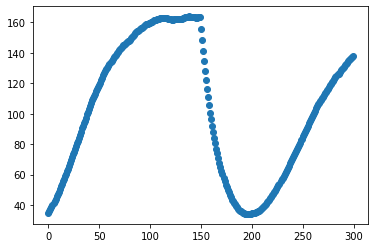

In [99]:
averageSimulationsWithDrug(False)

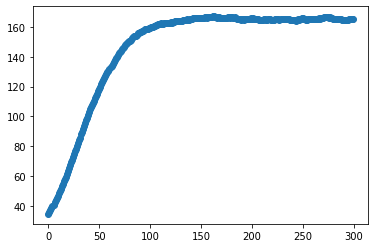

In [100]:
averageSimulationsWithDrug(True)

In [108]:
#
# PROBLEM 3
#        

def simulationDelayedTreatment(isResistantToGuttagonal, delay):

    """
    Runs simulations and make histograms for problem 5.
    Runs multiple simulations to show the relationship between delayed treatment
    and patient outcome.
    Histograms of final total virus populations are displayed for delays of 300,
    150, 75, 0 timesteps (followed by an additional 150 timesteps of
    simulation).    
    """
    viruses = []
    max_pop = 1000
    resistances = {'guttagonol':isResistantToGuttagonal} 
    for i in range (100):
        viruses.append(ResistantVirus(0.1, 0.05, resistances, 0.005))
    patient = Patient(viruses, max_pop)
    x_axis = []
    y_axis = []
    for step in range(delay):
        x_axis.append(step)
        y_axis.append(patient.update())
    # return x_axis, y_axis
    patient.addPrescription('guttagonol')
    for step in range(delay, delay+150):
        x_axis.append(step)
        y_axis.append(patient.update())
    matplotlib.pyplot.scatter(x_axis, y_axis)
    # return x_axis, y_axis

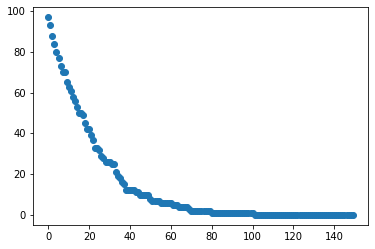

In [124]:
simulationDelayedTreatment(False, 0)

In [134]:
def getFinalPopulationDelayedTreatment(isResistantToGuttagonal, delay):
    viruses = []
    max_pop = 1000
    resistances = {'guttagonol':isResistantToGuttagonal} 
    for i in range (100):
        viruses.append(ResistantVirus(0.1, 0.05, resistances, 0.005))
    patient = Patient(viruses, max_pop)
    for step in range(delay):
        patient.update()
    # return x_axis, y_axis
    patient.addPrescription('guttagonol')
    for step in range(delay, delay+150):
        patient.update()
    return patient.getTotalPop()
    

In [140]:
getFinalPopulationDelayedTreatment(False, 0)

0

In [160]:
def histFinalPopulationDelayedTreatment(delay):
    population = []
    patients = 30
    for patient in range(patients):
        population.append(getFinalPopulationDelayedTreatment(False, delay))
    matplotlib.pyplot.hist(population, range=(0, 600))
    

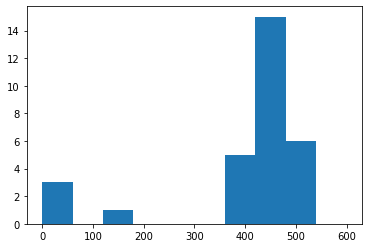

In [162]:
histFinalPopulationDelayedTreatment(150)

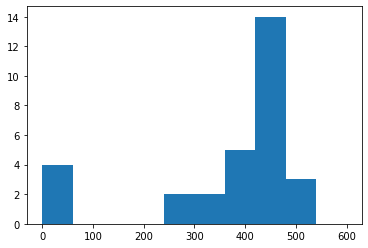

In [164]:
histFinalPopulationDelayedTreatment(75)

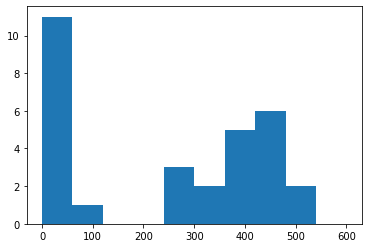

In [166]:
histFinalPopulationDelayedTreatment(50)

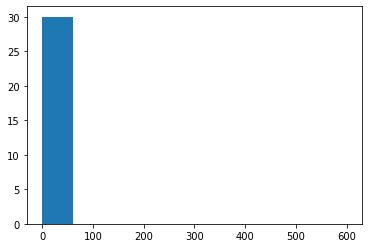

In [168]:
histFinalPopulationDelayedTreatment(0)

In [ ]:

#
# PROBLEM 4
#

def simulationTwoDrugsDelayedTreatment():

    """
    Runs simulations and make histograms for problem 6.
    Runs multiple simulations to show the relationship between administration
    of multiple drugs and patient outcome.
   
    Histograms of final total virus populations are displayed for lag times of
    150, 75, 0 timesteps between adding drugs (followed by an additional 150
    timesteps of simulation).
    """

    # TODO



#
# PROBLEM 5
#    

def simulationTwoDrugsVirusPopulations():

    """

    Run simulations and plot graphs examining the relationship between
    administration of multiple drugs and patient outcome.
    Plots of total and drug-resistant viruses vs. time are made for a
    simulation with a 300 time step delay between administering the 2 drugs and
    a simulations for which drugs are administered simultaneously.        

    """
    #TODO

In [ ]:
def simulationWithoutDrug():
    """
    Run the simulation and plot the graph for problem 2 (no drugs are used,
    viruses do not have any drug resistance).    
    Instantiates a patient, runs a simulation for 300 timesteps, and plots the
    total virus population as a function of time.    
    """
    viruses = []
    max_pop = 1000
    for i in range (100):
        viruses.append(SimpleVirus(0.1, 0.05))
    patient = SimplePatient(viruses, max_pop)
    x_axis = []
    y_axis = []
    for step in range(300):
        x_axis.append(step)
        y_axis.append(patient.getTotalPop())
        patient.update()
    return x_axis, y_axis

In [ ]:
def averageSimulationsWithDrug():
    x_result = []
    y_data = []
    y_result = []
    for q in range (100):
        x, y = simulationWithDrug()
        if len(x_result) == 0:
            x_result = x
        y_data.append(y)
    for y_row in range (len(y_data[0])):
        y_sum = 0 
        for y_column in range (len(y_data)):
            y_sum += y_data[y_column][y_row]
        y_result.append(y_sum / len(y_data[0]))
    print(len(y_result))
    matplotlib.pyplot.scatter(x_result, y_result)

300


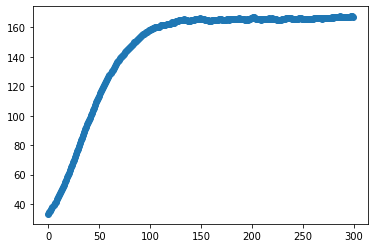

In [ ]:
averageSimulationsWithoutDrug()